# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [40]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train_p2.p'
testing_file = './traffic-signs-data/test_p2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [41]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.max() + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

('Number of training examples =', 39209)
('Number of testing examples =', 12630)
('Image data shape =', (32, 32, 3))
('Number of classes =', 43)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

<Container object of 43 artists>

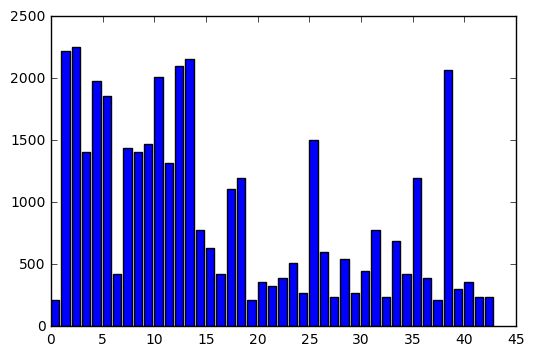

In [42]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

y_count = []
for idx in range(n_classes):
    cnt = y_train == idx
    cnt = cnt.astype(np.float32, copy=False)
    idx_n0 = cnt.nonzero()[0]
    y_count.append(cnt.sum())
    '''
    plt.figure(figsize=(1,1))
    plt.imshow(X_train[idx_n0[0]].squeeze())
    plt.title("ClassID is %d" % idx)
    '''
plt.figure()
plt.bar(np.arange(n_classes), np.array(y_count))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [43]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn.preprocessing import normalize

from scipy.signal.signaltools import convolve2d
from scipy.signal.windows import gaussian

def create_kernel(dim0, dim1):
    """Create a two-dimensional LPF kernel, with a half-Hamming window along
    the first dimension and a Gaussian along the second.
    Parameters
    ----------
    dim0 : int
        Half-Hamming window length.
    dim1 : int
        Gaussian window length.
    Returns
    -------
    kernel : np.ndarray
        The 2d LPF kernel.
    """
    dim0_weights = np.hamming(dim0 * 2 + 1)[:dim0]
    dim1_weights = gaussian(dim1, dim1 * 0.25, True)
    kernel = dim0_weights[:, np.newaxis] * dim1_weights[np.newaxis, :]
    return kernel / kernel.sum()

def lcn(X, kernel):
    """Apply Local Contrast Normalization (LCN) to an array.
    Parameters
    ----------
    X : np.ndarray, ndim=2
        Input representation.
    kernel : np.ndarray
        Convolution kernel (should be roughly low-pass).
    Returns
    -------
    Z : np.ndarray
        The processed output.
    """
    if X.ndim != 2:
        raise ValueError("Input must be a 2D matrix.")
    Xh = convolve2d(X, kernel, mode='same', boundary='symm')
    V = X - Xh
    S = np.sqrt(convolve2d(np.power(V, 2.0),
                kernel, mode='same', boundary='symm'))
    S2 = np.zeros(S.shape) + S.mean()
    S2[S > S.mean()] = S[S > S.mean()]
    if S2.sum() == 0.0:
        S2 += 1.0
    return V / S2

def normalize_input(X_data, kernel):
    eps = 1e-5
    for idx in xrange(len(X_data)):
        X_data_y = X_data[idx, :, :, 0]
        X_data_y = (X_data_y - X_data_y.mean()) / np.max([X_data_y.std(), eps])
        X_data[idx, :, :, 0] = lcn(X_data_y, kernel)
    
    return X_data

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
It can be easily found that the quality of some images are quite low, even cannot be clearly differentiated by eyes. Besides, all the images are limited to the size of 32 by 32, which further deteriorate the classification. Therefore, how to improve the image contrast is the most important. As stated in [LeCun's paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), the RGB image is converted to [YCbCr](https://en.wikipedia.org/wiki/YCbCr), which is more perceptually meaningful. Thereafter, image processing could be implemented on Y-channel. Based on LeCun's paper, the global and local contrast normalization operations are applied on the Y-channel, where the local contrast normalization codes are adopted from [Humphrey's toolkit](https://github.com/ejhumphrey/dl4mir/blob/master/dl4mir/common/lcn.py). The testing accuracy on the test set exhibits the advantage of contrast enhancement over the original RGB input (testing accuracy improved from 90.3% to 93.6%).

In [44]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import copy

# Generate new data, Left & right mirror
mirror_id = {19: 20, 20: 19, 33: 34, 34: 33, 36: 37, 37: 36, 38: 39, 39: 38}

X_train_exp = copy.deepcopy(X_train)
y_train_exp = copy.deepcopy(y_train)

for idx in xrange(n_train):
    if y_train[idx] in mirror_id.keys():
        X_train_exp = np.vstack((X_train_exp, np.fliplr(X_train[idx])[np.newaxis, :, :, :]))
        y_train_exp = np.hstack((y_train_exp, np.array([mirror_id[y_train[idx]]])))

In [45]:
# Split train and validation dataset
X_train_sub_idx = np.arange(0, len(X_train_exp), 30)

y_types = [[] for i in range(n_classes)]

for idx in X_train_sub_idx:
    if idx + 30 <= n_train:
        y_types[y_train_exp[idx]].append(idx)
    
val_type = []    
for t in range(n_classes):
    idx_type = np.random.randint(len(y_types[t]))
    idx_sub = y_types[t][idx_type]
    val_type.append(range(idx_sub, idx_sub+30))

val_type = reduce(lambda x, y: x+y, val_type)

X_val = X_train_exp[val_type]
y_val = y_train_exp[val_type]

X_train_part = np.delete(X_train_exp, val_type, axis=0)
y_train_part = np.delete(y_train_exp, val_type, axis=0)

# X_test = X_test.astype(np.float32)

In [46]:
# Global and local contrast enhancement
kernel = create_kernel(3, 5)

from skimage.color import rgb2ycbcr

X_train_part_ycbcr = np.zeros(X_train_part.shape)
for idx in xrange(len(X_train_part)):
    X_train_part_ycbcr[idx] = rgb2ycbcr(X_train_part[idx]).astype(np.float32) / 255.0
    #X_train_part_ycbcr[idx] = X_train_part[idx].astype(np.float32) / 255.0
X_train_part_ycbcr = normalize_input(X_train_part_ycbcr, kernel)
    
X_val_ycbcr = np.zeros(X_val.shape)
for idx in xrange(len(X_val)):
    X_val_ycbcr[idx] = rgb2ycbcr(X_val[idx]).astype(np.float32) / 255.0    
    #X_val_ycbcr[idx] = X_val[idx].astype(np.float32) / 255.0    
X_val_ycbcr = normalize_input(X_val_ycbcr, kernel)    

X_test_ycbcr = np.zeros(X_test.shape)
for idx in xrange(len(X_test)):
    X_test_ycbcr[idx] = rgb2ycbcr(X_test[idx]).astype(np.float32) / 255.0
    #X_test_ycbcr[idx] = X_test[idx].astype(np.float32) / 255.0
X_test_ycbcr = normalize_input(X_test_ycbcr, kernel)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Generate more data

From sample investigation in Step 1, we may find that the sample statistics in different categories are not balanced, that is, some categories contain more samples. It is worth noting that, some categories are quite similar, such as "Turn right ahead" and "Turn left ahead", "Go straight or right" and "Go straight or left", where the left/right signs can be made to be right/left through simple left-side-right-side flip. Therefore, the traffic signs with left-side or right-side information can be adopted to supplement its opposite category, and vice verse. Based on this observation, the simplest way to augment the dataset is to flip the images from left to right or right to left in some categories. After this operation, the dataset is more balanced, and the experiments validate that the testing accuracy of different categories is more consistent.

2. Data split

The training dataset is made up of several short continuous frames (usually 30), where each short clip contains a single traffic sign. Therefore, totally random split of the training and validation set is not reasonable, which will make the validation set quite similar to the training set. Based on this observation, the strategy in LeCun's paper is adopted here, that is, randomly selecting one clip (30 frames) from each traffic sign category to construct the validation set which contains 1290 images in total, and the remaining images are adopted as the training set.

In [47]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))    
    
    conv1 = tf.nn.bias_add( tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID'), b1)
    
    # TODO: Activation.
    
    act1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    w2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    
    conv2 = tf.nn.bias_add( tf.nn.conv2d(pool1, w2, strides=[1, 1, 1, 1], padding='VALID'), b2 )
    
    # TODO: Activation.
    
    act2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.

    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    fl1 = flatten(pool2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    
    w3 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    
    fc1 = tf.nn.bias_add( tf.matmul(fl1, w3), b3 )
    
    # TODO: Activation.
    
    act3 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    
    w4 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    
    fc2 = tf.nn.bias_add( tf.matmul(act3, w4), b4 )
    
    # TODO: Activation.
    
    act4 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    
    w5 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(43))
    
    logits = tf.nn.bias_add( tf.matmul(act4, w5), b5 )
    
    return logits

keep_prob = 0.5

def LeNet2(x, test_mode):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))    
    
    conv1 = tf.nn.bias_add( tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID'), b1)
    
    # TODO: Activation.
    
    act1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    w2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    
    conv2 = tf.nn.bias_add( tf.nn.conv2d(pool1, w2, strides=[1, 1, 1, 1], padding='VALID'), b2 )
    
    # TODO: Activation.
    
    act2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.

    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16 and 14x14x6. Output = 1576.
    
    fl1 = tf.concat(1, [flatten(pool2), flatten(pool1)])
    
    # TODO: Layer 3: Fully Connected. Input = 1576. Output = 120.
    
    w3 = tf.Variable(tf.truncated_normal([1576, 120], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    
    fc1 = tf.nn.bias_add( tf.matmul(fl1, w3), b3 )
    
    # TODO: Activation.
    
    act3 = tf.nn.relu(fc1)
    
    act3 = tf.cond(test_mode, lambda: act3, lambda: tf.nn.dropout(act3, keep_prob=keep_prob))

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    
    w4 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    
    fc2 = tf.nn.bias_add( tf.matmul(act3, w4), b4 )
    # logits = tf.nn.bias_add( tf.matmul(act3, w4), b4 )
    
    # TODO: Activation.
    
    act4 = tf.nn.relu(fc2)
    act4 = tf.cond(test_mode, lambda: act4, lambda: tf.nn.dropout(act4, keep_prob=keep_prob))
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    
    w5 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(43))
    
    logits = tf.nn.bias_add( tf.matmul(act4, w5), b5 )
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The LeCun's neural network has been successfully applied to hand-written digits recognition, therefore it may give us a good point to start. The LeCun's neural network contains two convolutional layers and three fully connected layers. But different from the original LeCun's network, the first pooling layer output is also adopted to serve as the input of the full connection layer, just like that in [LeCun's paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). The purpose of this action is to combine local information from lower layer with the global information from upper layer, which may bring some benefits for classification (the experiment validates that it does improve the classification accuracy). Besides, it can also be observed that the training set accuracy can quickly converge to 1, while the validation accuracy may ascend slowly. That may tell that the training may be a little over-fitting. Therefore, two dropout layers are adopted.

In [48]:
### Train your model here.
### Feel free to use as many code cells as needed.

learning_rate = 0.001
epochs = 30
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y, n_classes)
test_mode = tf.placeholder(tf.bool)

logits = LeNet2(x, test_mode)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.cast( tf.equal( tf.argmax(logits, 1), tf.argmax(one_hot_y, 1) ), tf.float32 )
accuracy_prediction = tf.reduce_mean(correct_prediction)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_prediction, feed_dict={x: batch_x, y: batch_y, test_mode: True})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def evaluate_test(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = np.array([])
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(correct_prediction, feed_dict={x: batch_x, y: batch_y, test_mode: True})
        if len(total_accuracy) == 0:
            total_accuracy = accuracy
        else:
            total_accuracy = np.hstack([total_accuracy, accuracy])
    return total_accuracy

In [53]:
from sklearn.utils import shuffle

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train_part)
    
    print("Training ...")
    for i in range(epochs):
        X_train_part_shuffle, y_train_part_shuffle = shuffle(X_train_part_ycbcr, y_train_part)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_part_shuffle[offset:end], y_train_part_shuffle[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, test_mode: True})
        train_accuracy = evaluate(X_train_part_ycbcr, y_train_part)
        validation_accuracy = evaluate(X_val_ycbcr, y_val)
        print("Epoch %d" % i)
        print("Train accu: %f" % train_accuracy)
        print("Validation accu: %f" % validation_accuracy)
    
    saver.save(sess, "./lenet_traffic_sign")
    print("Model saved")

Training ...
Epoch 0
Train accu: 0.940096
Validation accu: 0.834884
Epoch 1
Train accu: 0.972350
Validation accu: 0.906977
Epoch 2
Train accu: 0.987573
Validation accu: 0.891473
Epoch 3
Train accu: 0.988512
Validation accu: 0.908527
Epoch 4
Train accu: 0.996970
Validation accu: 0.948837
Epoch 5
Train accu: 0.995490
Validation accu: 0.919380
Epoch 6
Train accu: 0.993469
Validation accu: 0.906202
Epoch 7
Train accu: 0.993446
Validation accu: 0.896899
Epoch 8
Train accu: 0.996053
Validation accu: 0.909302
Epoch 9
Train accu: 0.998778
Validation accu: 0.942636
Epoch 10
Train accu: 0.998356
Validation accu: 0.933333
Epoch 11
Train accu: 0.992530
Validation accu: 0.896899
Epoch 12
Train accu: 0.994761
Validation accu: 0.924031
Epoch 13
Train accu: 0.996758
Validation accu: 0.913178
Epoch 14
Train accu: 0.998356
Validation accu: 0.937209
Epoch 15
Train accu: 0.999413
Validation accu: 0.944186
Epoch 16
Train accu: 0.997087
Validation accu: 0.923256
Epoch 17
Train accu: 0.998403
Validation accu

Test accu: 0.942597


<Container object of 43 artists>

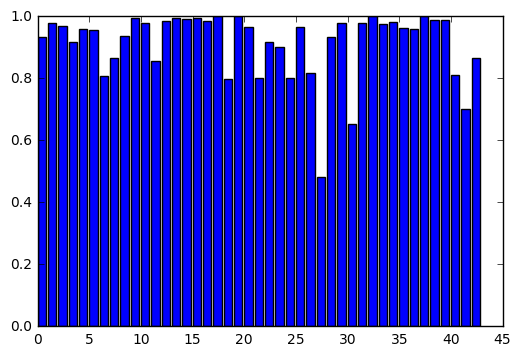

In [54]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test_ycbcr, y_test)
    print("Test accu: %f" % test_accuracy)
    test_accuracy_full = evaluate_test(X_test_ycbcr, y_test)

test_accu_type = [[] for i in xrange(n_classes)]

for idt in xrange(n_classes):
    cnt = y_test == idt
    idx = cnt.nonzero()
    test_accu_type[idt] = test_accuracy_full[idx].mean()
    
plt.figure()
plt.bar(np.arange(n_classes), np.array(test_accu_type))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The Adam optimizer is utilized. Compared with SGD, it lifts the burden of learning rate tuning, which doesn't need to be rigidly set. The batch size is usually set to be squares of 2. To balance the memory cost and training speed, 128 is set. The local contrast normalization from [Humphrey's toolkit](https://github.com/ejhumphrey/dl4mir/blob/master/dl4mir/common/lcn.py) has two hyper-parameters, the Hamming window length and Gaussian window length. These two parameters, together with the epochs parameter, are empirically set to be 3, 5 and 30.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
The most important part is, of course, the feature extraction and classification, which are realized by a neural network. LeCun's CNN (in 92) is a good start point. In the first try, a 2-layer convolution following 3-layer fully connection with 43-dimensional output is utilized for classification, just like the experiments in previous lectures. The input is a 3-channel RGB image with dimension 32x32. The network is trained on the randomly selected training set (not totally random indeed), and gives a testing accuracy about 89%, not a bad start.

By observing several training images, it can be found that some of them are of low quality, even cannot be distinguished by eyes. Therefore, to further improve the testing accuracy, the contrast improvement operation is necessary. A global plus local contrast normalization strategy is adopted from LeCun's paper (in 11), which manipulates the Y-channel after converting the original RGB image to YCbCr image. After this step, the testing accuracy gets to 92%.

After careful observation of different traffic sign categories, we may find that some sorts of traffic signs are symmetric about each other, specifically those ones with left/right information. By flipping those traffic signs left to right/right to left, we could produce the opposite. Meanwhile, it is worth noting that, those opposite signs about left/right information are not balanced, such as the "keep right" with samples more than 2000, while "keep left" less than 500. Obviously, the flipping operation could reasonably augment the training samples. After this step, the testing accuracy gets to almost 93%.

As LeCun's paper stated, they concatenated the first pooling layer with the second pooling layer to form the input of fully connected layer. The benefit is that they could combine the global and local information. This structure is also adopted to further improve performance. However, that will make the fully connected layer dimension boost from 400 to 1576. One concern is that the boosted variables may cause over-fit. Therefore, a dropout layer is added after each fully connected layer. The final testing accuracy arrives at more than 94%.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [77]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import skimage.io
import skimage.transform

In [78]:
imgnames = os.listdir("./wildimages/")

X_wild = np.zeros([len(imgnames), 32, 32, 3])
y_wild = np.zeros(len(imgnames), dtype=np.int32)

for idx in xrange(len(imgnames)):
    imgname = imgnames[idx]
    name, ext = os.path.splitext(imgname)
    y_wild[idx] = int(name)
    img = skimage.io.imread(os.path.join("./wildimages", imgname))
    img = skimage.transform.resize(img, [32, 32, 3])
    X_wild[idx] = img

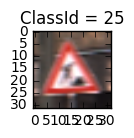

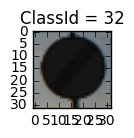

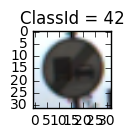

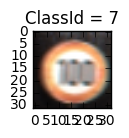

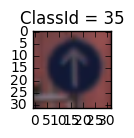

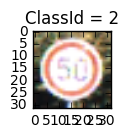

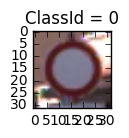

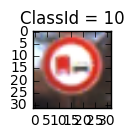

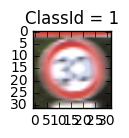

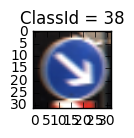

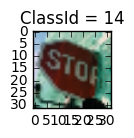

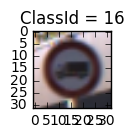

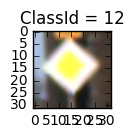

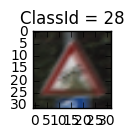

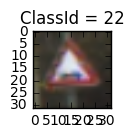

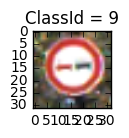

In [79]:
for idx in xrange(len(X_wild)):
    plt.figure(figsize=(1, 1))
    plt.imshow(X_wild[idx])
    plt.title("ClassId = %d" % y_wild[idx])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
16 testing samples are given, 15 of whom are cropped from [German Traffic Sign Detection Benchmark](http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset), except the stop sign download from internet. Those images usually have low resolution, and some are a little blurry or with low contrast. But the testing results are pretty good. Three samples are tested wrong, the "road closed" sign, the "stop" sign and the "bumpy road" sign. The "stop" sign is partially corrupted while the "bumpy road" sign is not very clear. As for the "road closed" sign, it is indeed not included in the training set.

In [80]:
X_wild_ycbcr = np.zeros(X_wild.shape)
for idx in xrange(len(X_wild)):
    X_wild_ycbcr[idx] = rgb2ycbcr(X_wild[idx]).astype(np.float32) / 255.0
X_wild_ycbcr = normalize_input(X_wild_ycbcr, kernel)

In [101]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
probs = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, "./lenet_traffic_sign")
    prob_wild = sess.run(probs, feed_dict={x: X_wild_ycbcr, test_mode:True})
    accuracy_wild = evaluate(X_wild_ycbcr, y_wild)
    print("Wild Test accu: %f" % accuracy_wild)
    accuracy_wild_single = evaluate_test(X_wild_ycbcr, y_wild)

Wild Test accu: 0.812500


In [116]:
# The prediction accuracy for each single sample
print accuracy_wild_single

[ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
2 out of 15 testing samples are wrong, that is, testing accuracy is 87%. It is interesting to see that, the "road closed" sign is predicted to be the "yield" sign with really high confidence. The "yield" sign is also empty inside, but the shape is totally different.

In [115]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### The error case top-5 prediction
for idx in xrange(len(X_wild_ycbcr)):
    if accuracy_wild_single[idx] == 0:
        sort_imgs = np.argsort(prob_wild[idx])
        print(sort_imgs[-1:-6:-1], y_wild[idx]) # The top-5 IDs, and the last one is the ground-truth
        print(prob_wild[idx][sort_imgs[-1:-6:-1]]) # The top-5 probabilities

(array([15, 39, 12,  4,  8]), 0)
[  1.00000000e+00   7.30280382e-15   6.95929522e-16   2.71589653e-16
   1.49058039e-16]
(array([ 3, 34, 38,  1, 36]), 14)
[  9.61611032e-01   2.39313561e-02   1.43258162e-02   9.08001821e-05
   2.15833734e-05]
(array([29, 23, 34, 38,  3]), 22)
[  6.37383103e-01   3.61494035e-01   4.95669432e-04   4.37345414e-04
   1.88442325e-04]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Except the "Road closed" sign that is not included in the training set, the 13 correct predictions are all with high confidence. However, the 2 incorrect predictions are both with quite low confidence (even not included in the top-5 predictions). Even that, the top-2 predictions of "Bumpy road" are quite similar to the ground-truth. The "stop" sign is really hard to predict. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [103]:
with tf.Session() as sess:
    val, ind = sess.run(tf.nn.top_k(tf.constant(prob_wild), k=3))

In [104]:
# top-3 prediction probability
print val

[[  9.99999285e-01   4.46285640e-07   9.98741427e-08]
 [  9.99957204e-01   2.19686353e-05   1.62959932e-05]
 [  9.99981880e-01   1.81487794e-05   2.97439984e-09]
 [  9.99999881e-01   7.92348729e-08   6.04754078e-08]
 [  1.00000000e+00   8.96552391e-14   2.99257170e-17]
 [  9.99999523e-01   3.60041668e-07   5.97804046e-08]
 [  1.00000000e+00   7.30280382e-15   6.95929522e-16]
 [  9.99996424e-01   3.63118625e-06   3.93404547e-13]
 [  1.00000000e+00   3.38243922e-08   4.84560791e-09]
 [  1.00000000e+00   2.81485797e-23   6.08806796e-24]
 [  9.61611032e-01   2.39313561e-02   1.43258162e-02]
 [  1.00000000e+00   5.28065314e-10   2.26993099e-12]
 [  1.00000000e+00   1.74630506e-16   3.53041267e-20]
 [  9.99999166e-01   4.28619273e-07   3.99232988e-07]
 [  6.37383103e-01   3.61494035e-01   4.95669432e-04]
 [  9.99995470e-01   4.38530060e-06   1.59777827e-07]]


In [112]:
# the first 3 columns are the top-3 prediction IDs, and the last column is the ground-truth
# the 7th is the "road closed" sign, which is not included, and just set to be 0 arbitrarily
print np.hstack([ind, np.reshape(y_wild, [16, 1])])

[[25 31 29 25]
 [32 42 41 32]
 [42 10 41 42]
 [ 7 10  8  7]
 [35 37 36 35]
 [ 2 39  1  2]
 [15 39 12  0]
 [10  9 23 10]
 [ 1  5  0  1]
 [38 31 36 38]
 [ 3 34 38 14]
 [16  7 40 16]
 [12  1 15 12]
 [28 20 25 28]
 [29 23 34 22]
 [ 9 10 15  9]]
